Code to correct the aberration mainly introcuded by the R11 SLM. This work is based on Mark Neil's Matlab code:`startestWFSnew.m`.

In [58]:
import sys
print(sys.path)

['/Users/maan/HexSimInstrument', '/usr/local/Cellar/python@3.9/3.9.16/Frameworks/Python.framework/Versions/3.9/lib/python39.zip', '/usr/local/Cellar/python@3.9/3.9.16/Frameworks/Python.framework/Versions/3.9/lib/python3.9', '/usr/local/Cellar/python@3.9/3.9.16/Frameworks/Python.framework/Versions/3.9/lib/python3.9/lib-dynload', '', '/usr/local/lib/python3.9/site-packages', '/usr/local/lib/python3.9/site-packages/IPython/extensions', '/Users/maan/.ipython']


In [1]:
import numpy as np
# import cupy as cp
cp = None
from scipy.signal import convolve2d
import scipy.ndimage
import matplotlib.pyplot as plt
import time
from IPython import display
import cv2
# import cupyx.scipy.ndimage
import opt_einsum as oe

# Aberration correction simulation

In [2]:
xp = np
# titles = ['Guess for PSF intensity', 'Phase sum in pupil', 'Phase difference in pupil', 'Amplitude in pupil', 'Amplitude profile in pupil', 'Unwrapped PSF phase', 'Unwrapped PSF phase difference', 'Simulated phase aberration', 'Simulated phase aberration sum', 'Measured PSF', 'Measured PSF+defocus', 'Measured PSF-defocus'
titles = ['Guess for PSF intensity', 'Phase sum in pupil', 'Phase difference in pupil', 'Amplitude in pupil', 'Amplitude profile in pupil', 'Unwrapped PSF phase', 'Zernike fitted phase', 'Simulated phase aberration', 'Simulated phase aberration sum', 'Measured PSF', 'Measured PSF+defocus', 'Measured PSF-defocus']

In [3]:
# Scaling calculation all distances in µm

# camera pixel size
d_c = 5.04
# camera roi size
N = 256

# slm pixel size
d_s = 8.2
# slm roi size
n_s = 2048

# fourier focal length
f = 300e3
# wavelength
l = 0.52

In [4]:
# Sampling in pupil plane
s_p = f * l / (N * d_c)
print(f's_p = {s_p:.3f}')

# pupil plane diameter in pixels
d_p = n_s * d_s / s_p
print(f'd_p = {d_p:.3f}')

s_p = 120.908
d_p = 138.896


In [5]:
# Scaling from pupil plane to SLM plane
s_fac = n_s / d_p
print(f's_fac = {s_fac:.3f}') 

s_fac = 14.745


Set up arrays and Chebyshev polynomials

In [6]:
xx = xp.linspace(-N / d_p, N / d_p, N)
m = np.abs(xx) < 1
ne = (N - sum(m)) // 2  # 1/2 number of elements along side of pupil
xx *= m

# weight function along 1-d
wtx = (1 / xp.sqrt(1 - (xx ** 2))) * m
# find correctiom to end element that makes Ch[0]*Ch[2]*wtx = 0
s = xp.sum(wtx * (2 * xx ** 2 - 1) )
df = s / (2 * xx[ne] ** 2 - 1) / 2
wtx[ne] -= df
wtx[-ne - 1] = wtx[ne]

# Now calculate 2-d weights
x, y = xp.meshgrid(xx, xx)
circ = xp.outer(m, m)
wt = xp.outer(wtx, wtx)
r = xp.sqrt(x ** 2 + y ** 2)

# weight the target PSF towards the centre (or not if all ones)
G = xp.ones((int(N), int(N)))

n_c = 5
n_p = 4

def set_C(xc, yc, n_c):
    ch = xp.zeros((n_c, n_c, N, N))
    for n in range(n_c):
        for k in range(n_c):
            c = np.zeros((n + 1, k + 1))
            c[n, k] = 1
            ch[n, k, :, :] = np.polynomial.chebyshev.chebval2d(xc, yc, c) * circ
    return ch
        
chs = set_C(x, y, 5)
        
c_a_p = xp.reshape(chs, (n_c ** 2, N, N)) # Chebyshev aberration for phase
c_a_i = xp.reshape(chs[:n_p, :n_p, :, :], (n_p ** 2, N, N))  # Chebyshev aberration for intensity   
normval_p = 1 / oe.contract('ijk, ijk, jk -> i', c_a_p, c_a_p, wt)
normval_i = 1 / oe.contract('ijk, ijk, jk -> i', c_a_i, c_a_i, wt)


In [7]:
print(s, df)
xp.sum(wtx * (2 * xx ** 2 - 1) )

-11.39397511765134 -5.927805542608094


3.552713678800501e-15

In [8]:
wtx[ne]

13.09463632757

In [9]:
xp.sum(wtx)

217.7802353539562

Chebyshev aberrations

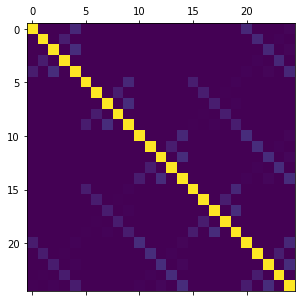

In [10]:
# Orthononality matrix diagonal gives normalisation
plt.matshow(xp.sqrt(xp.abs(oe.contract('ijk, mjk, jk, m -> im', c_a_p, c_a_p, wt, normval_p))))

In [11]:
with np.printoptions(precision=3, suppress=True):
    print(oe.contract('ijk, mjk, jk, i -> im', c_a_p, c_a_p, wt, normval_p))

[[ 1.     0.     0.     0.    -0.006  0.     0.    -0.    -0.     0.
   0.     0.     0.    -0.    -0.     0.    -0.     0.     0.     0.
  -0.006 -0.     0.    -0.     0.   ]
 [ 0.     1.     0.    -0.006  0.    -0.     0.    -0.    -0.     0.
   0.    -0.     0.    -0.     0.    -0.     0.     0.    -0.     0.
   0.    -0.006 -0.     0.    -0.   ]
 [-0.     0.     1.     0.    -0.016  0.    -0.     0.     0.    -0.
  -0.     0.     0.     0.     0.    -0.     0.     0.    -0.    -0.
   0.    -0.    -0.006 -0.     0.   ]
 [ 0.    -0.006  0.     1.     0.     0.    -0.     0.     0.    -0.
  -0.    -0.     0.     0.     0.    -0.    -0.    -0.     0.    -0.
  -0.     0.    -0.    -0.006  0.   ]
 [-0.013  0.    -0.016  0.     1.     0.     0.    -0.    -0.     0.
   0.    -0.     0.     0.    -0.    -0.     0.     0.     0.     0.
   0.    -0.     0.    -0.    -0.006]
 [ 0.     0.    -0.     0.    -0.     1.     0.     0.     0.    -0.006
   0.     0.    -0.     0.     0.    -0.006  0. 

In [12]:
xp.sum(chs[0,0] * chs[2,0] * wt)

5.271338920920243e-13

In [13]:
wt.max()

171.46950055131595

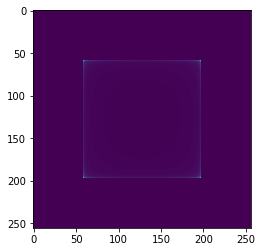

In [14]:
plt.imshow(wt)

## Chebyshev expansion by orthogonality at nodal points

In [15]:
p_s = np.polynomial.chebyshev.chebpts1(n_c + 1)
ch_xs, ch_ys = xp.meshgrid(p_s, p_s)

In [16]:
def set_Cs(xc, yc, n_s):
    ch = xp.zeros((n_s, n_s, n_s + 1, n_s + 1))
    for n in range(n_s):
        for k in range(n_s):
            c = np.zeros((n + 1, k + 1))
            c[n, k] = 1
            ch[n, k, :, :] = np.polynomial.chebyshev.chebval2d(xc, yc, c)
    return ch
        
chs_s = set_Cs(ch_xs, ch_ys, n_c)
        
c_a_ps = xp.reshape(chs_s, (n_c ** 2, n_c + 1, n_c + 1)) # Chebyshev aberration for phase
c_a_is = xp.reshape(chs_s[:n_p, :n_p, :, :], (n_p ** 2, n_c + 1, n_c + 1))  # Chebyshev aberration for intensity   
normval_ps = 1 / oe.contract('ijk, ijk -> i', c_a_ps, c_a_ps)
normval_is = 1 / oe.contract('ijk, ijk -> i', c_a_is, c_a_is)
nm = sum(m)


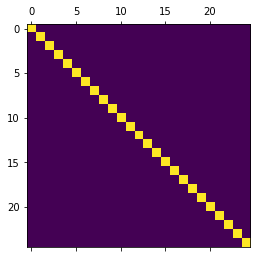

In [17]:
# Orthononality matrix diagonal gives normalisation
plt.matshow(np.sqrt(np.abs(oe.contract('ijk, mjk, i -> im', c_a_ps, c_a_ps, normval_ps))))
# with np.printoptions(precision=3, suppress=True):
#     print(oe.contract('ijk, mjk, i -> im', c_a_ps, c_a_ps, normval_ps))

<Figure size 432x288 with 0 Axes>

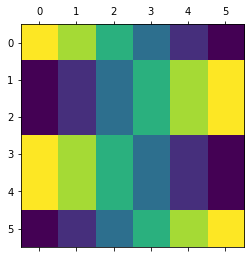

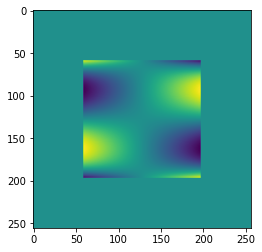

In [18]:
xi = np.zeros((n_c + 1, n_c + 1, 2))
xi[:, :, 0] = ch_ys
xi[:, :, 1] = ch_xs
c_interp = np.zeros_like(c_a_ps)
for i in range(n_c * n_c):
    c_interp[i, :, :] = scipy.interpolate.interpn((xx[m], xx[m]), 
                                                   c_a_p[i, circ].reshape((nm, nm)), 
                                                   xi, method='splinef2d')
plt.figure()
plt.matshow(c_interp[8])
plt.figure()
plt.imshow(c_a_p[8])

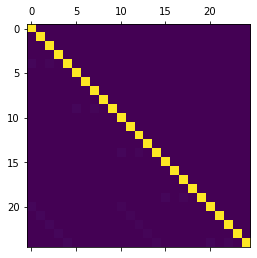

In [19]:
# Orthononality matrix for interpolated data diagonal gives normalisation
plt.matshow(np.abs(oe.contract('ijk, mjk, i -> im', c_interp, c_a_ps, normval_ps)) ** 0.25)

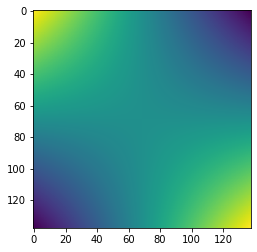

In [20]:
plt.imshow(c_a_p[6,circ].reshape((nm, nm)))

## SLM's aberration
### Random phase
Create a random image with low spatial frequency content for aberration to be measured

In [40]:
# ri = (30 * ch[1, 3] + 2 * ch[3, 1] - 5 * ch[4, 4] + 
#       7 * ch[4, 1] + 5 * ch[2, 2] - 2 * ch[3, 3]) * circ / 0.5

c = xp.random.rand(n_c, n_c) - 0.5
ri = np.polynomial.chebyshev.chebval2d(x, y, c) * circ
rms = xp.std(ri)
RMS = 10
ri *= RMS / rms

# starting random input phase
ri2 = (-18 * chs[1, 1] + 5 * chs[2, 2] - 7 * chs[3, 1] + 11 * chs[3, 3]) * circ / 4  

Work out measured PSFs for the 3 applied masks

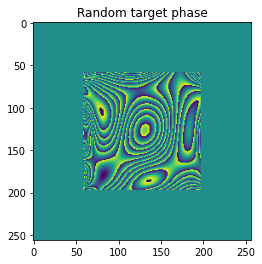

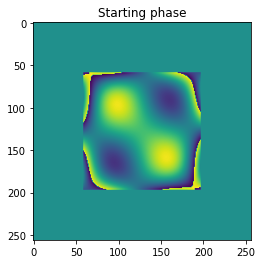

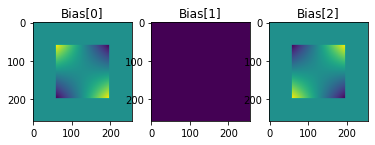

In [41]:
plt.figure(100)
if xp == cp:
    plt.imshow((xp.angle(xp.exp(1j * ri))).get())
else:
    plt.imshow(xp.angle(xp.exp(1j * ri)))
plt.title('Random target phase')

sumc = xp.sum(circ)
piston = xp.sum(xp.sum(ri * circ)) / sumc
diff = (ri-piston) * circ
rms = xp.sqrt(xp.sum(diff ** 2) / sumc)

plt.figure(101)
if xp == cp:
    plt.imshow(xp.angle(xp.exp(1j*ri2)).get())
else:
    plt.imshow(xp.angle(xp.exp(1j*ri2)))
plt.title('Starting phase')

plt.figure(102)
defocus = 5 * (chs[0, 2] + chs[2, 0])
# bias = [10 * (chs[0, 2] - chs[2, 0]), 40 * chs[1, 1], -10 * (chs[0, 2] - chs[2, 0])]
bias = [40 * chs[1, 1], 0 * chs[1, 1], -40 * chs[1, 1]]
for i in range(3):
    plt.subplot(1, 3, i + 1)
    if xp == cp:
        plt.imshow(bias[i].get())
    else:
        plt.imshow(bias[i])
    plt.title(f'Bias[{i}]')

ampl = circ * xp.exp(-((x - 0.25) ** 2 + 2 * y ** 2) / 2 / 1 ** 2)  # funny gaussian illumination to simulate a laser beam scenario; sigma=1

In [42]:
nphot = 1e8  # Number of photons per detected image
bg = xp.ones((int(N), int(N))) * 0  # background

### 3 PSFs
Apply three masks

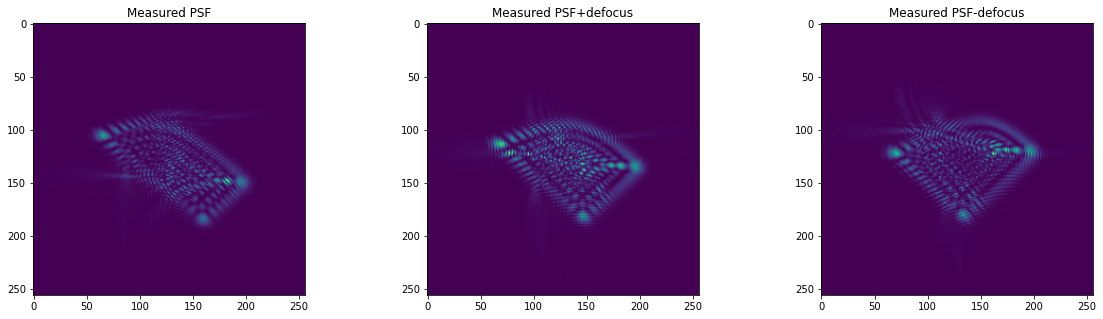

In [46]:
masks = [ri + bias[0], ri + bias[1], ri + bias[2]]
psfi = [None, None, None]  # psf intensity
psfn = [None, None, None]
plt.figure(figsize=(20,5))
for i in range(3):
    p1 = xp.fft.fftshift(xp.fft.fft2(ampl * xp.exp(1j * masks[i])))
    p1i = xp.abs(p1) ** 2 / xp.sum(xp.abs(p1) ** 2) * nphot + bg
    p1i_n = (xp.random.poisson(p1i) - bg) * G
    ps = p1i_n  # PSF intensity with noise
    plt.subplot(1, 3, i + 1)
    plt.title(titles[9 + i])
    if xp == cp:
        plt.imshow(ps.get())
    else:
        plt.imshow(ps)
    psfi[i] = p1i_n + 0j


## Iteration loop to correct aberrations

In [47]:
cuml_phase = xp.zeros((N, N))
Q = circ * xp.exp(1j * ri2)
rms_plot = []
cuml_z = xp.zeros(len(c_a_p))

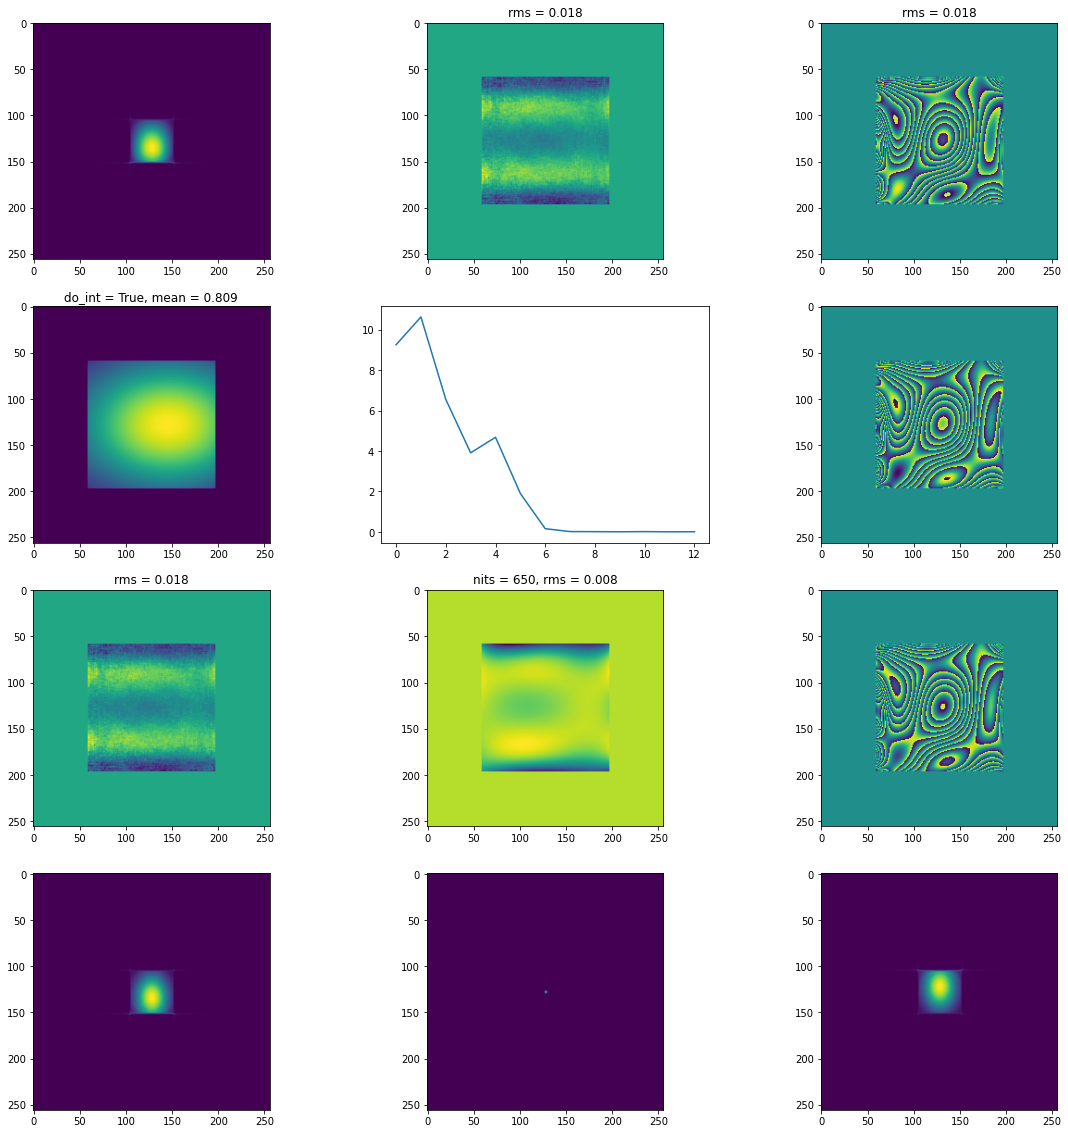

Elapsed time: 46.62710618972778s
[ 41.309   4.817  -6.851   6.393 -10.651   7.421  -0.207  -6.532  -6.027
   5.954   0.195  -7.769  -9.185   1.42   -7.194  -0.918   1.246  -8.517
   5.751   6.209  -6.808   9.77    8.456   2.032 -10.336]
Total rms phase = 21.636


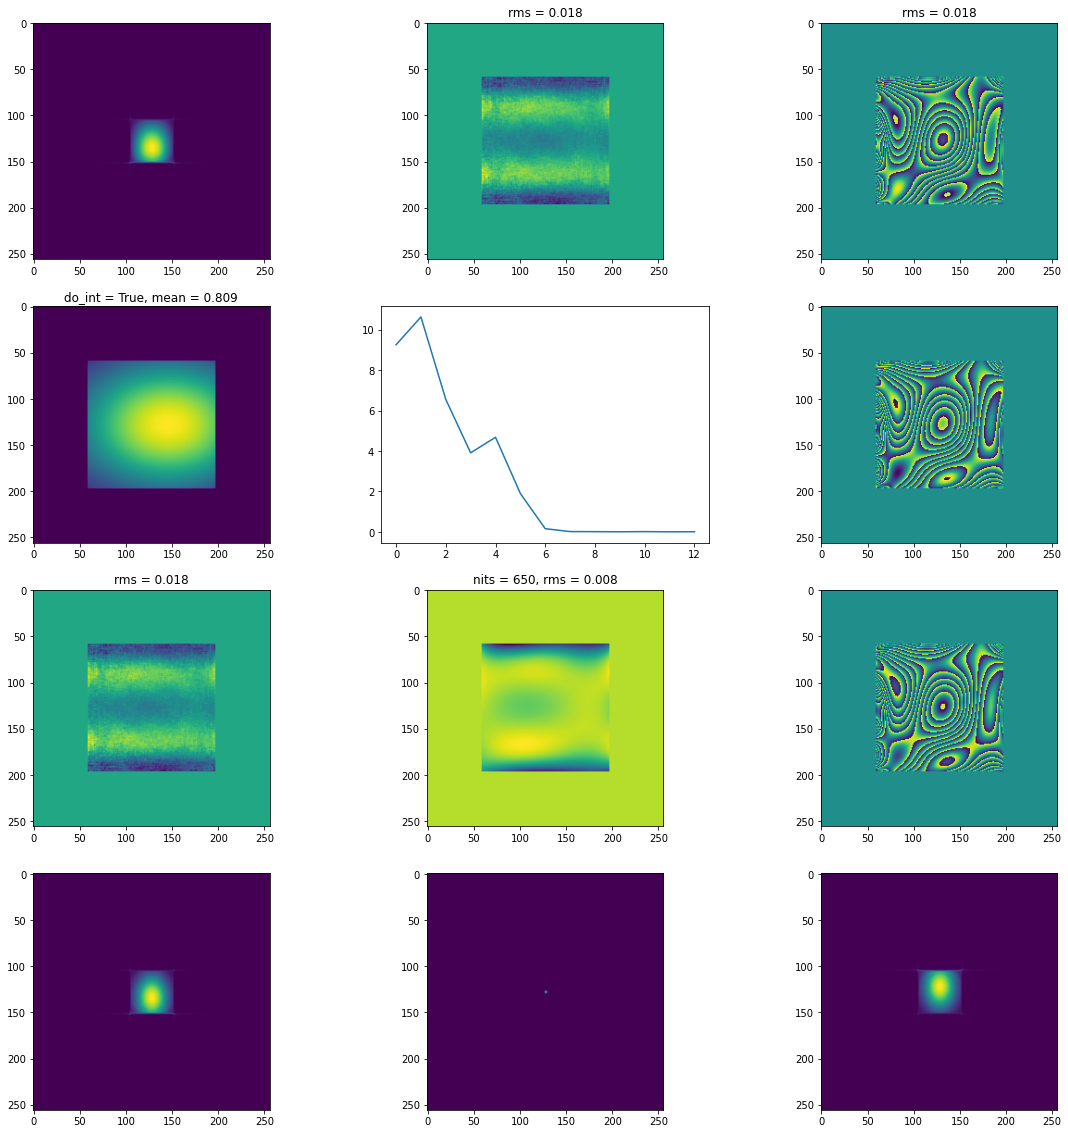

In [48]:
# method = 'weighted'  # two methods for chebyshev orthogonality, "weighted' or 'sampled'
method = 'sampled'

show_ani = True
if show_ani:
    f = plt.figure(figsize=(20,20))
    axes = []
    for i in range(12):
        axes.append(f.add_subplot(4,3,i+1))

def show_animation(k, img, title=None):
    if show_ani:
        axes[k].clear()
        if xp == cp:
            s = axes[k].imshow(img.get())
        else:
            s = axes[k].imshow(img)
        if not title is None:
            axes[k].set_title(title)
        if k == 11:
            display.clear_output(wait=True)
            display.display(axes[k].get_figure())

t0 = time.time()
nits = 1
n = 50
error = 0
psfn0 = [None, None, None]

do_int = False
last_rms = 10.0

while nits < n * 20 + 1:
    q1 = xp.fft.fftshift(xp.fft.fft2(Q * xp.exp(1j * bias[0])))
    q2 = xp.fft.fftshift(xp.fft.fft2(Q * xp.exp(1j * bias[1])))
    q3 = xp.fft.fftshift(xp.fft.fft2(Q * xp.exp(1j * bias[2])))

    if xp.mod(nits, n) == 0:
        show_animation(0, abs(q1) ** 2)

    Q1 = xp.fft.ifft2(xp.fft.fftshift(xp.sqrt(psfi[0]) * xp.exp(1j * xp.angle(q1))))
    Q1 = Q1 * circ * xp.exp(-1j * bias[0])
    Q2 = xp.fft.ifft2(xp.fft.fftshift(xp.sqrt(psfi[1]) * xp.exp(1j * xp.angle(q2))))
    Q2 = Q2 * circ * xp.exp(-1j * bias[1])
    Q3 = xp.fft.ifft2(xp.fft.fftshift(xp.sqrt(psfi[2]) * xp.exp(1j * xp.angle(q3))))
    Q3 = Q3 * circ * xp.exp(-1j * bias[2])

    Q = Q1 + Q2 + Q3
    Qc = xp.angle(Q) * circ

    if xp.mod(nits, n) == 0:
        rms = xp.std(Qc[circ])
        show_animation(1, Qc, f'rms = {rms:.3f}')

    if xp.mod(nits,n) == 0:
        diff = xp.angle(Q * xp.exp(-1j * ri)) * circ
        show_animation(2, diff, f'rms = {rms:.3f}')

    # Constrain intensity in pupil to have slowly varying values by fitting to Zernike polynomials, up to radial order
    # 4 to help with gaussian illumination
    if do_int:
        z_i = oe.contract('ijk, jk, jk, i -> i', c_a_i, xp.abs(Q), wt, normval_i) 
        Qb = oe.contract('ijk, i -> jk', c_a_i, z_i)
    else:  # Set the amplitude to a uniform pupil if the phase is still changing a lot
        if last_rms < 2 * np.pi:
            do_int = True
        Qb = circ

    if xp.mod(nits,n) == 0:
        show_animation(3, abs(Q), f'do_int = {do_int}, mean = {np.mean(Qb[circ]):.3f}')
        
    # set the amplitude, keep the phase
    Q = Qb * xp.exp(1j * Qc)
    
    if xp.mod(nits, n) == 0:
        # Smooth the phase and grab new psfs after applying the partial correction

        # Unwrap the phase
        Qc[N//2:, :] = xp.unwrap(Qc[N//2:, :], axis=0)
        Qc = xp.flipud(Qc)
        Qc[N//2:, :] = xp.unwrap(Qc[N//2:, :], axis=0)
        Qc[:, N//2:] = xp.unwrap(Qc[:, N//2:], axis=1)
        Qc = xp.fliplr(Qc)
        Qc[:, N//2:] = xp.unwrap(Qc[:, N//2:], axis=1)
        Qc = xp.flipud(xp.fliplr(Qc)) * circ
        
        show_animation(5,xp.angle(xp.exp(1j * ri)))

        rms_d = xp.std(Qc[circ])
        show_animation(6, Qc, f'rms = {rms_d:.3f}')

        # Constrain phase in pupil to have slowly varying values by fitting to Zernike
        if method == 'weighted':
            diff_z = oe.contract('ijk, jk, jk, i -> i', c_a_p, Qc, wt, normval_p) 
        else:
            Qc_s = scipy.interpolate.interpn((xx[m], xx[m]), 
                                             Qc[circ].reshape((nm, nm)),
                                             xi, method='splinef2d')
            diff_z = oe.contract('ijk, jk, i -> i', c_a_ps, Qc_s, normval_ps)
        diff = oe.contract('ijk,i->jk', c_a_p, diff_z)
        #subtract the fitted phase from our current pupil guess
        Q = Q * xp.exp(-1j * diff)

        # Calculate rms of fitted phase 
        rms_dz = np.std(diff)
        show_animation(7, diff, f'nits = {nits}, rms = {rms_dz:.3f}')
        
        # Plot the fitted RMS values so far
        if xp == cp:
            rms_plot.append(rms_dz.get())
        else:
            rms_plot.append(rms_dz)
        if show_ani:
            axes[4].clear()
            axes[4].plot(rms_plot)

        # calculate the cummulative zernike mode values and reconstruct the cummulative phase
        cuml_z += diff_z
        cuml_phase = oe.contract('ijk,i->jk', c_a_p, cuml_z)
        show_animation(8, xp.angle(xp.exp(1j * cuml_phase)))

        # Recalculate the psfs
        new_masks = [ri - cuml_phase + bias[0], ri - cuml_phase + bias[1], ri - cuml_phase + bias[2]]  

        for i in range(3):
            p1 = xp.fft.fftshift(xp.fft.fft2(ampl * xp.exp(1j * new_masks[i])))
            p1i = abs(p1) ** 2 / xp.sum(abs(p1) ** 2) * nphot + bg
            p1i_n = (xp.random.poisson(p1i) - bg) * G
            ps = p1i_n
            show_animation(9+i,ps)
            psfi[i] = p1i_n + 0j
        
        # Stop if rms is small enough for two consecutive iterations
        if rms_dz < 0.01 and last_rms < 0.01:
            break
        else:
            last_rms = rms_dz
    nits = nits + 1

print(f'Elapsed time: {time.time() - t0}s')
with np.printoptions(precision=3, suppress=True):
    print(cuml_z)
print(f'Total rms phase = {xp.std(cuml_phase):.3f}')


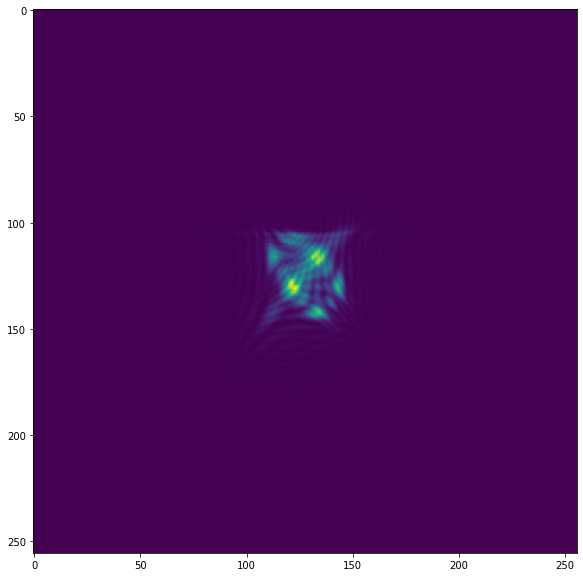

In [32]:
plt.figure(figsize=(10,10))
plt.imshow(psfi[2].real)

In [85]:
xp.sum(Q * xp.exp(1j * cumphase) * (Z22 + 1j * Z2_2) / 2) 

NameError: name 'cumphase' is not defined

In [86]:
xp.sum(Q * xp.exp(1j * cumphase) * (Z22 - 1j * Z2_2) / (2 * 1j)) 

NameError: name 'cumphase' is not defined

In [ ]:
xp.sum(Q * xp.exp(1j * cumphase) * (Z22 + Z2_2) / 2) 

In [86]:
xp.std(cumphase, where=circ)

31.736370521209906

In [98]:
diff = oe.contract('ijk,i->jk', z_array, diff_z)
xp.std(Z1_1, where=circ)

0.9998028195133947

In [103]:
np.linalg.norm(diff_z)

0.016933889573170727

In [43]:
# Scaling calculation all distances in µm

# camera pixel size
d_c = 5.04
# camera roi size
n_c = 256

# slm pixel size
d_s = 8.2
# slm roi size
n_s = 2048

# fourier focal length
f = 300e3
# wavelength
l = 0.52

In [44]:
# Sampling in pupil plane
s_p = f * l / (n_c * d_c)
print(f's_p = {s_p:.3f}')

# pupil plane diameter in pixels
d_p = n_s * d_s / s_p
print(f'd_p = {d_p:.3f}')

s_p = 120.908
d_p = 138.896


In [45]:
# Scaling from pupil plane to SLM plane
s_fac = n_s / d_p
print(f's_fac = {s_fac:.3f}') 

s_fac = 14.745


In [46]:
# Sampling in camera plane from SLM
s_c = f * l / (n_s * d_s)
print(f's_c = {s_c:.3f}')

s_c = 9.289


In [47]:
d_c / (s_c / 2) * 128

138.89599015384613

In [48]:
d_p / 128

1.085124923076923

In [69]:
np.packbits(phi.astype('int'))

array([75], dtype=uint8)

In [53]:
# if not show_ani:
#     imgs = []
#     fig = plt.figure()
#     for i in range(12):
#         plt.subplot(6, 2, i)
#         if xp == cp:
#             plt.imshow()
#         plt.imshow()
#         plt.title(titles[i])

In [54]:
plt.figure()
if xp == cp:
    plt.imshow(xp.angle(xp.exp(1j * (cumphase))).get())
#     plt.imshow(cumphase.get())
# plt.figure()
# if xp == cp:
#     plt.imshow((xp.angle(xp.exp(1j * cumphase))).get())

<Figure size 432x288 with 0 Axes>

AttributeError: 'numpy.ndarray' object has no attribute 'get'

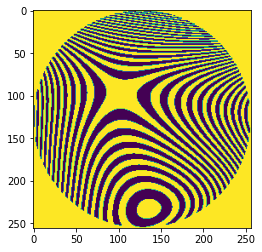

In [55]:
bi_phi = (xp.real(xp.exp(1j * cumphase))) > 0 * xp.pi
plt.figure()
if xp == cp:
    plt.imshow(xp.angle(xp.exp(1j * (bi_phi))).get())
else:
    plt.imshow(xp.angle(xp.exp(1j * (bi_phi))))
hol = xp.angle(xp.exp(1j * (bi_phi))).get()
cv2.imwrite('hol_test.png', hol, [cv2.IMWRITE_PNG_BILEVEL, 1])

In [ ]:
aaa = cupyx.scipy.ndimage.zoom((xp.real(xp.exp(1j * cumphase))) > 0 * xp.pi, 8, order=0)
plt.imshow(aaa.get())
print(aaa.shape)

In [ ]:
plt.figure(100)
if xp == cp:
    plt.imshow(xp.angle(xp.exp(1j * (ri))).get())
else:
    plt.imshow(xp.angle(xp.exp(1j * (ri))))
plt.title('Random target phase')

In [44]:
# zs = xp.zeros((1,21))
# Qc = cumphase

# # Constrain phase in pupil to have slowly varying values by fitting to Zernike
# Z_list = [Z00, Z11, Z1_1, Z20, Z22, Z2_2, Z31, Z3_1, Z33, Z3_3, Z40, Z42, Z4_2, Z44, Z4_4, Z51, Z5_1, Z53, Z5_3, Z55, Z5_5]

# for i in range(21):
#     zs[0, i] = xp.sum(Qc * Z_list[i])
# zs = zs/normval

Tried to make the retrived phase bianary, but failed. The PSF is too good to believe.

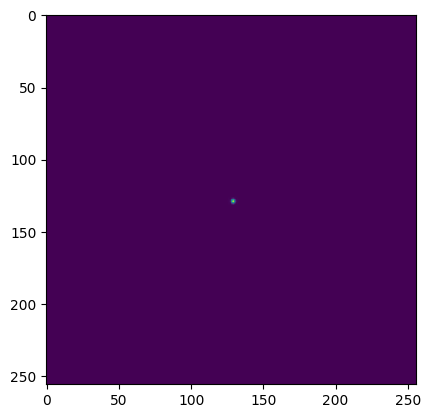

In [46]:
plt.figure()
p1 = xp.fft.fftshift(xp.fft.fft2(ampl * xp.exp(1j * (ri-cumphase)), (2*N, 2*N)))
p1i = abs(p1) ** 2 / xp.sum(abs(p1) ** 2) * nphot + bg
p1i_n = (xp.random.poisson(p1i) - bg) * G
psf_test = p1i_n[int(N/2-1):int(3*N/2-1), int(N/2-1):int(3*N/2-1)]
if xp == cp:
    plt.imshow(abs(psf_test).get())
else:
    plt.imshow(abs(psf_test))

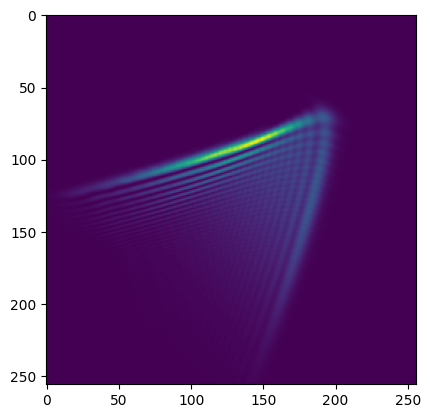

In [86]:
plt.figure()
p1 = xp.fft.fftshift(xp.fft.fft2(ampl * xp.exp(1j * (cumphase)), (2*N, 2*N)))
p1i = abs(p1) ** 2 / xp.sum(abs(p1) ** 2) * nphot + bg
p1i_n = (xp.random.poisson(p1i) - bg) * G
psf_test = p1i_n[int(N/2-1):int(3*N/2-1), int(N/2-1):int(3*N/2-1)]
if xp == cp:
    plt.imshow(abs(psf_test).get())
else:
    plt.imshow(abs(psf_test))

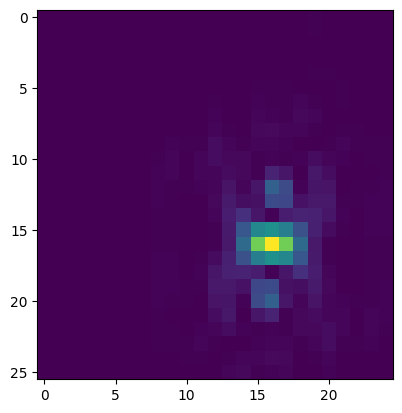

In [110]:
plt.imshow(abs(psfi[2]).get()[240:266, 240:265])

In [20]:
plt.figure()
p1 = xp.fft.fftshift(xp.fft.fft2(ampl * xp.exp(1j * (ri-bi_phi)), (2*N, 2*N)))
p1i = abs(p1) ** 2 / xp.sum(abs(p1) ** 2) * nphot + bg
p1i_n = (xp.random.poisson(p1i) - bg) * G
psf_test = p1i_n[int(N/2-1):int(3*N/2-1), int(N/2-1):int(3*N/2-1)]
if xp == cp:
    plt.imshow(abs(psf_test).get())
else:
    plt.imshow(abs(psf_test))

NameError: name 'bi_phi' is not defined

<Figure size 640x480 with 0 Axes>

In [21]:
plt.figure()
p1 = xp.fft.fftshift(xp.fft.fft2(ampl * xp.exp(1j * (bi_phi)), (2*N, 2*N)))
p1i = abs(p1) ** 2 / xp.sum(abs(p1) ** 2) * nphot + bg
p1i_n = (xp.random.poisson(p1i) - bg) * G
psf_test = p1i_n[int(N/2-1):int(3*N/2-1), int(N/2-1):int(3*N/2-1)]
if xp == cp:
    plt.imshow(abs(psf_test).get())
else:
    plt.imshow(abs(psf_test))

NameError: name 'bi_phi' is not defined

<Figure size 640x480 with 0 Axes>

In [1175]:
print(psfi[0][138])

[ 0.          0.          0.          0.          0.          0.
  0.          0.         -0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.          0.
  0.          0.          0.          0.          0.          0.
 -0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.          0.         -0.         -0.          0.          0.
  0.          0.          0.          0.         -0.         -0.
  0.          0.          0.          0.         -0.         -0.
 -0.          0.         -0.          0.          0.          0.
 -0.          0.          0.          0.          0.          0.
 -0.         -0.          0.          0.         -0.          0.
  0.          0.          0.          0.         -0.         -0.
  0.         -0.          0.          0.          0.          0.
  0.         -0.         

In [984]:
bi_phi.mean()

array(57.22026953)

In [985]:
ri.mean()

array(1.00986456)

In [986]:
cumphase.mean()

array(-18.65401583)

In [968]:
ri.max() -ri.min()

array(61.30535486)

In [987]:
cumphase.max() -cumphase.min()

array(61.84224315)

In [988]:
bi_phi.max() - bi_phi.min()

array(1.)

In [989]:
np.max(cumphase)

array(5.01079808)

In [564]:
xp.sum(psfi[0])

array(69116157.32964002+0.j)

In [475]:
cumphase_norm.max()

array(6.25224269)